# Basic statistics on subgraphs 

This notebook showcases how to easily get (weighted) averages of node and edge based properties across neighborhoods or the simplicial structure. 

In [1]:
from connalysis.network import local, topology
from connalysis.network import stats as nstats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the connectome (see the "Loading_the_data" notebook)
from helpers import read_connectomes
data_dir="data" # You chosen data directory 
# Loading Celegans connectome 
conn=read_connectomes.load_C_elegans_stages(data_dir).filter("type").eq("chemical").default(8)
conn.add_vertex_property('valid_cell', (topology.node_degree(conn.matrix)!=0)) 
conn=conn.index("valid_cell").isin(True)  
adj=conn.matrix
adj.eliminate_zeros()

Warning!!! When accessing the adjacency as a sparse matrix using the .matrix property:
    Connections that are not present at a given stage, but at other stages will be represented as edges,
    but with a value of ``0`` synapses associated with them.  For structural analysis always use .eliminate_zeros


/gpfs/bbp.cscs.ch/home/egassant/basic_connalysis_tutorial/helpers/read_connectomes.py:174: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges_chem = syns_chem.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)
/gpfs/bbp.cscs.ch/home/egassant/basic_connalysis_tutorial/helpers/read_connectomes.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges_elec = syns_elec.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)


## Computing node based and edge based data

We first precompute edge and node participation, in order to generate synthetic data for analysis. 

In [3]:
node_par = topology.node_participation(adj)
edge_par = topology.edge_participation(adj)

 2024-05-29 14:53:58,232: Done running flagser


We consider two types data, possibly activity data: 

* **node based**: one value per node e.g., size of its neighborhood or realiability of of that neuron's activity.
* **edge based**: one vakye per edge e.g., correlation of the activity of connected pairs.  


To showcase the methods we will use the size of a neighborhood of each node and the average size of the neighborhoods of all connected nodes.

We first compute all neighborhoods.

In [4]:
nbds = local.neighborhood_indices(adj)
display(nbds)

center
0      [2, 6, 10, 32, 38, 42, 43, 44, 45, 47, 54, 55,...
1      [3, 11, 15, 33, 42, 43, 44, 45, 49, 54, 74, 77...
2      [0, 3, 25, 42, 43, 57, 68, 70, 72, 74, 82, 88,...
3      [1, 2, 17, 24, 26, 42, 43, 47, 49, 57, 71, 73,...
4      [10, 12, 13, 18, 20, 32, 40, 53, 60, 62, 63, 6...
                             ...                        
214                  [17, 30, 34, 68, 72, 102, 109, 121]
215     [3, 15, 16, 22, 35, 37, 102, 107, 109, 121, 140]
216                                            [87, 121]
217                                        [83, 85, 171]
218                                                 [90]
Name: neighbors, Length: 219, dtype: object

We now compute their sizes and the average for each connected pair

In [5]:
nbd_size = nbds.apply(len)+1
sources, targets = zip(*list(edge_par.index))
av_nbd_size_edge = pd.Series(nbd_size.iloc[np.array(sources)].to_numpy()+nbd_size.iloc[np.array(targets)].to_numpy(), 
                             index = edge_par.index)

## We can now do basic averages of these across neighborhoods and the higher order structure

### Average on neighborhoods

You can get average values of a node property across neighborhoods.  If your graph is small you can compute the neighborhoods on the fly. 

In [6]:
nstats.node_stats_neighborhood(nbd_size, adj)

,sum,mean,std,sem
center,,,,
0,693,24.750000,6.478674,1.246821
1,576,26.181818,7.767276,1.694959
2,760,25.333333,8.092521,1.502743
3,747,23.343750,8.745032,1.570654
4,481,25.315789,9.078909,2.139919
...,...,...,...,...
214,174,19.333333,8.679478,3.068659
215,229,19.083333,9.376018,2.826976
216,55,18.333333,13.572849,9.597453


In general, it is more efficient to precompute the neighborhoods and pass them directly to the function.

In [7]:
nbd_av=nstats.node_stats_neighborhood(nbd_size, include_center=True,precomputed=True,neighborhoods=nbds)

Unsurprisingly, the size of a neighborhood is strongly correlated to the sum of the neighborhoods of the node it contains.  This relationship is weaker if we instead consider the for the incoming and outgoing neighborhoods instead, due to the directionality of the network.

Text(0, 0.5, 'Sum of neighborhood sizes')

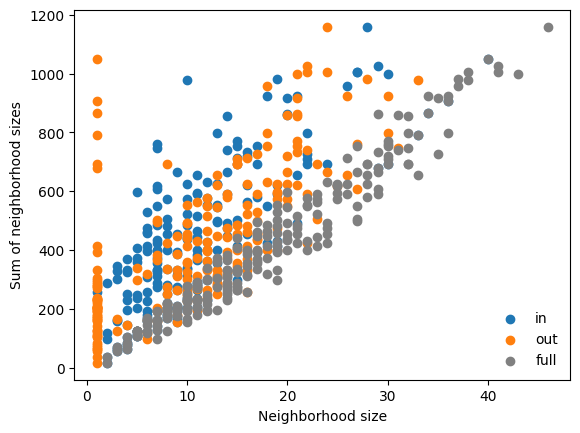

In [8]:
nbds_in = local.neighborhood_indices(adj, pre=True, post=False)
nbds_out = local.neighborhood_indices(adj, pre=False, post=True)

# Plotting 
plt.scatter(nbds_in.apply(len)+1, nbd_av["sum"], label ="in")
plt.scatter(nbds_out.apply(len)+1, nbd_av["sum"], label="out")
plt.scatter(nbd_size, nbd_av["sum"], label="full", color="gray")
plt.legend(frameon=False)
plt.xlabel("Neighborhood size") 
plt.ylabel("Sum of neighborhood sizes") 


# Average across the higher order structure 

### Node based properties

We can compute the average value of a node based property on the nodes that belong to a k-dimensional simplex in a single line. 
Make sure you understand the output of this function.

* What should the values in dimension 0 mean?
* What should the values in dimension 1 mean?
* What is the weighted mean?

In [9]:
import operator 
df_nodes_ge = nstats.node_stats_participation(node_par,nbd_size, condition=operator.ge)
df_nodes_ge 

,counts,mean,std,sem,weighted_mean
dim,,,,,
0,219,18.223744,9.422124,0.638147,18.223744
1,219,18.223744,9.422124,0.638147,23.433211
2,217,18.373272,9.335223,0.635181,26.209358
3,194,19.819588,8.782799,0.632200,28.540746
4,135,22.925926,8.251267,0.712801,31.344529
5,51,28.294118,8.008070,1.132512,33.223601
6,11,32.363636,4.959339,1.568281,33.229730


We can also compute the average value of a node based property on the nodes that belong to a k-dimensional simplex but not to a higher dimensional one. Make sure you understand the output of this function.  In particular:

* How is it different from the above?  What is it relationship to maximal simplices?
* What should the values in dimension 0 mean?
* What should the values in dimension 1 mean?

In [10]:
df_nodes_eq = nstats.node_stats_participation(node_par,nbd_size, condition=operator.eq)
df_nodes_eq

/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/connalysis/network/stats.py:140: RuntimeWarning: invalid value encountered in scalar divide
  w_mean = c.apply(np.product, axis=1).sum() / (c["weight"].sum())
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.

,counts,mean,std,sem,weighted_mean
dim,,,,,
0,0,NaN,NaN,NaN,NaN
1,2,2.000000,0.000000,0.000000,2.000000
2,23,6.173913,2.258360,0.481484,7.186047
3,59,12.711864,5.025531,0.659885,15.054400
4,84,19.666667,6.508846,0.714439,22.599015
5,40,27.175000,8.318316,1.331997,32.566275
6,11,32.363636,4.959339,1.568281,33.229730


Note that there is an effect/relationship between the size of a neighborhood and how central it is in terms of it's higher structure.  This is why randomized controls are important for these kind of analyses.  

Text(0, 0.5, 'Neigborhood size')

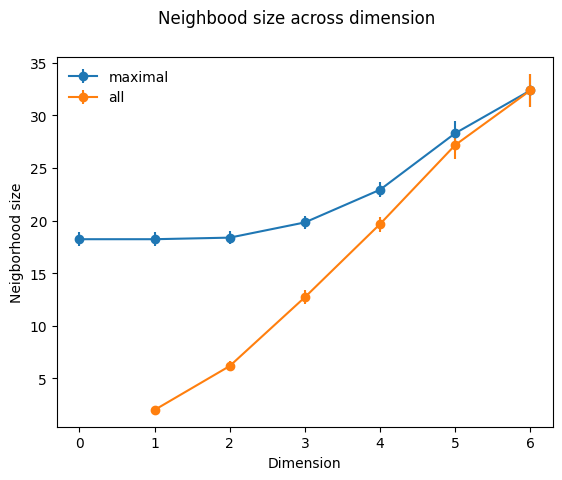

In [11]:
plt.suptitle("Neighbood size across dimension") 
plt.errorbar(df_nodes_ge.index, df_nodes_ge["mean"],yerr=df_nodes_ge["sem"], label="maximal", marker="o")
plt.errorbar(df_nodes_eq.index, df_nodes_eq["mean"], yerr=df_nodes_eq["sem"],label="all", marker="o")
plt.legend(frameon=False)
plt.xlabel("Dimension") 
plt.ylabel("Neigborhood size") 

When you have time, check out ``nstats.node_stats_per_position`` or ``nstats.node_stats_per_position_single``, which do the same analysis as before but only for nodes in a fixed position.  Think about the following things before doing this analysis: 

* What is the position about the node in a simplex?

### Edge based properties

There are properties which are more naturally thought of as edge based properties e.g. correlation

In [12]:
df_edges_ge = nstats.edge_stats_participation(edge_par, av_nbd_size_edge, condition=operator.ge)
df_edges_eq = nstats.edge_stats_participation(edge_par, av_nbd_size_edge, condition=operator.eq)
display(df_edges_ge,df_edges_eq)

/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/connalysis/network/stats.py:256: RuntimeWarning: invalid value encountered in scalar divide
  w_mean = c.apply(np.product, axis=1).sum() / (c["weight"].sum())
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/connalysis/network/stats.py:256: RuntimeWarning: invalid value encountered in scalar divide
  w_mean = c.apply(np.product, axis=1).sum() / (c["weight"].sum())
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/home/egassant/conndemo/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  retu

,counts,mean,std,sem,weighted_mean
dim,,,,,
1,2186,46.866423,13.623935,0.291459,46.866423
2,2102,47.296384,13.588249,0.296449,52.418716
3,1719,49.188482,13.575740,0.327531,57.081492
4,1049,53.491897,12.858776,0.397209,62.689058
5,277,61.675090,11.381275,0.685072,66.447203
6,58,65.568966,7.017496,0.929490,66.459459


,counts,mean,std,sem,weighted_mean
dim,,,,,
1,84,36.107143,9.461725,1.038559,36.107143
2,383,38.804178,9.898481,0.506450,40.260967
3,670,42.450746,11.814479,0.456774,43.102651
4,772,50.555699,12.064411,0.434489,53.444183
5,219,60.643836,12.071367,0.817576,66.420760
6,58,65.568966,7.017496,0.929490,66.459459


Based on the above, understand what the output of the commands above means.  This is a natural analysis to do on correlation type data. 

Text(0, 0.5, 'Neigborhood size')

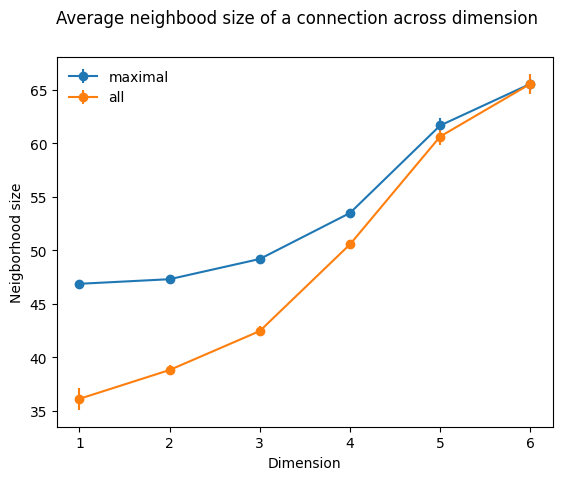

In [13]:
plt.suptitle("Average neighbood size of a connection across dimension") 
plt.errorbar(df_edges_ge.index, df_edges_ge["mean"], yerr=df_edges_ge["sem"],label="maximal", marker="o")
plt.errorbar(df_edges_eq.index, df_edges_eq["mean"], yerr=df_edges_eq["sem"],label="all", marker="o")
plt.legend(frameon=False)
plt.xlabel("Dimension") 
plt.ylabel("Neigborhood size") 